# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.17KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

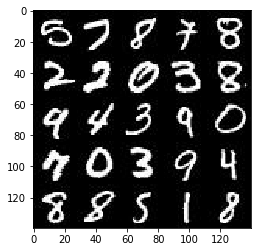

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

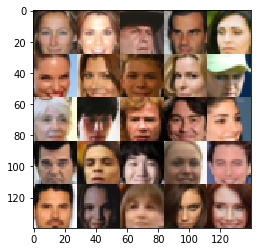

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, lr

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):       
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())        
        #x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # flatten into 1
        flatten = tf.reshape(x3, (-1, 2*2*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    
    return (out, logits)

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)        
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 16x16x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)        
        return out

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1 - 0.1)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    step = 0
    
    samples, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                steps += 1
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 0.8824
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 1.7493... Generator Loss: 0.5861
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 1.4644
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.1194
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.3521
Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.3482


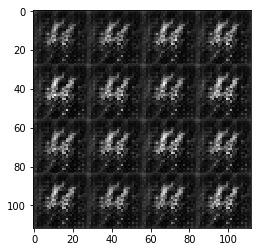

Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 2.2565
Epoch 1/2... Discriminator Loss: 0.8469... Generator Loss: 1.4572
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 2.0686
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 1.5738
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 1.4678
Epoch 1/2... Discriminator Loss: 0.5667... Generator Loss: 2.3833
Epoch 1/2... Discriminator Loss: 0.6560... Generator Loss: 2.2195
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 1.1769


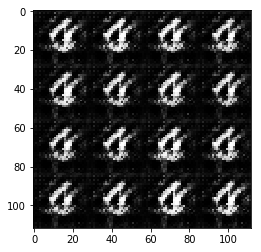

Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 2.4082
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 2.8032
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 2.1731
Epoch 1/2... Discriminator Loss: 0.6428... Generator Loss: 2.0181
Epoch 1/2... Discriminator Loss: 0.6852... Generator Loss: 2.2120
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 2.0916
Epoch 1/2... Discriminator Loss: 0.5757... Generator Loss: 2.2393
Epoch 1/2... Discriminator Loss: 0.9109... Generator Loss: 2.9233
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.8952


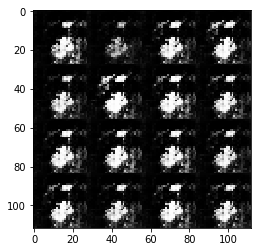

Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 0.8276... Generator Loss: 1.3238
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.8674
Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 2.3720
Epoch 1/2... Discriminator Loss: 0.9191... Generator Loss: 1.5934
Epoch 1/2... Discriminator Loss: 0.6081... Generator Loss: 1.8389
Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 2.0887
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 2.6847
Epoch 1/2... Discriminator Loss: 0.5342... Generator Loss: 2.7874
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 2.1469


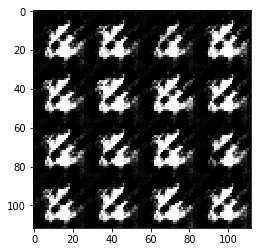

Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 3.8255
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 2.2533
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 1.9997
Epoch 1/2... Discriminator Loss: 0.6196... Generator Loss: 2.0240
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 1.9374
Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 2.5810
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 3.0959
Epoch 1/2... Discriminator Loss: 0.5613... Generator Loss: 2.9617
Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 2.0747
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 2.8665


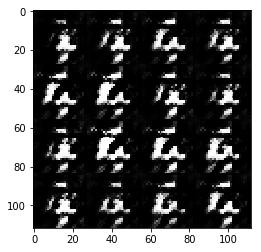

Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 3.0197
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 1.3785
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 2.0564
Epoch 1/2... Discriminator Loss: 0.7757... Generator Loss: 1.6653
Epoch 1/2... Discriminator Loss: 1.6200... Generator Loss: 2.6649
Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 1.1724
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.5931
Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 3.5238
Epoch 1/2... Discriminator Loss: 0.7167... Generator Loss: 2.3009


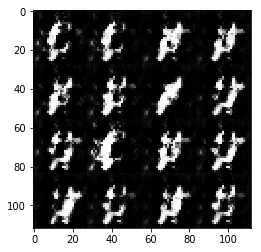

Epoch 1/2... Discriminator Loss: 0.6346... Generator Loss: 2.8597
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 2.0992
Epoch 1/2... Discriminator Loss: 0.6410... Generator Loss: 2.0606
Epoch 1/2... Discriminator Loss: 0.6501... Generator Loss: 1.6319
Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 2.8187
Epoch 1/2... Discriminator Loss: 0.6520... Generator Loss: 1.9789
Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 4.1910
Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 1.9912
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 2.5271
Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 2.4756


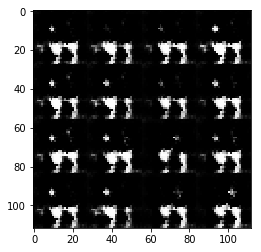

Epoch 1/2... Discriminator Loss: 0.4640... Generator Loss: 2.9773
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 2.7491
Epoch 1/2... Discriminator Loss: 0.4523... Generator Loss: 3.3198
Epoch 1/2... Discriminator Loss: 0.4522... Generator Loss: 2.9585
Epoch 1/2... Discriminator Loss: 0.4635... Generator Loss: 3.2860
Epoch 1/2... Discriminator Loss: 0.5454... Generator Loss: 2.3261
Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 1.0885
Epoch 1/2... Discriminator Loss: 0.6003... Generator Loss: 1.9487
Epoch 1/2... Discriminator Loss: 0.6170... Generator Loss: 1.8301
Epoch 1/2... Discriminator Loss: 0.5460... Generator Loss: 2.2278


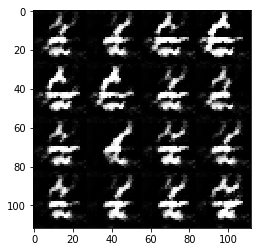

Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.8853
Epoch 1/2... Discriminator Loss: 0.7407... Generator Loss: 2.0665
Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 1.6804
Epoch 1/2... Discriminator Loss: 0.6232... Generator Loss: 2.3660
Epoch 1/2... Discriminator Loss: 0.5557... Generator Loss: 2.2508
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 2.3804
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 1.7150
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 1.5923
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 1.8045
Epoch 1/2... Discriminator Loss: 1.5807... Generator Loss: 4.8945


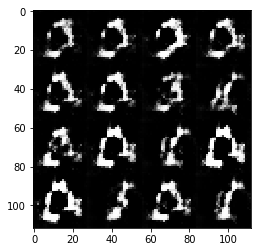

Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 1.0706
Epoch 1/2... Discriminator Loss: 0.7013... Generator Loss: 1.6545
Epoch 1/2... Discriminator Loss: 0.6175... Generator Loss: 1.9610
Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 1.8105
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.2141
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 3.1627
Epoch 1/2... Discriminator Loss: 1.7924... Generator Loss: 4.5241
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.3962
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.1638


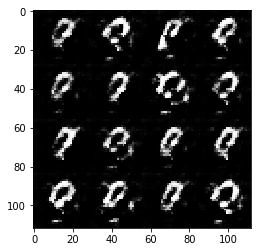

Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 1.3769
Epoch 1/2... Discriminator Loss: 0.7638... Generator Loss: 1.8118
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 2.0665
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 2.1671
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.2877
Epoch 1/2... Discriminator Loss: 0.7201... Generator Loss: 1.5740
Epoch 1/2... Discriminator Loss: 0.8267... Generator Loss: 1.4941
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 2.2815
Epoch 1/2... Discriminator Loss: 0.7481... Generator Loss: 2.1114


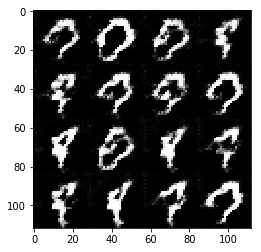

Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.4611
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 2.1322
Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 2.3059
Epoch 1/2... Discriminator Loss: 0.6144... Generator Loss: 2.6365
Epoch 1/2... Discriminator Loss: 0.7039... Generator Loss: 2.1319
Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 2.2324
Epoch 1/2... Discriminator Loss: 0.7645... Generator Loss: 1.8886
Epoch 1/2... Discriminator Loss: 0.7125... Generator Loss: 2.5164
Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 3.5409
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 1.9490


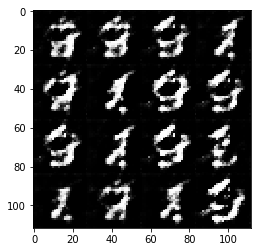

Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 2.3581
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 2.0655
Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 1.8340
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 4.0594
Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 2.7302
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 2.3471
Epoch 1/2... Discriminator Loss: 0.6588... Generator Loss: 2.7495
Epoch 1/2... Discriminator Loss: 0.8893... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 1.4373


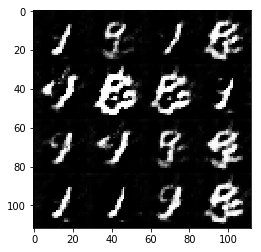

Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.3303
Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 1.9960
Epoch 1/2... Discriminator Loss: 0.7959... Generator Loss: 2.4005
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 1.6446
Epoch 1/2... Discriminator Loss: 0.7885... Generator Loss: 1.5811
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 1.1032
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 1.7244
Epoch 1/2... Discriminator Loss: 0.7936... Generator Loss: 2.1827


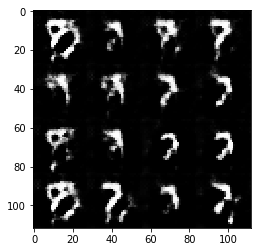

Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 1.8828
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 2.4164
Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 1.4762
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.6325
Epoch 1/2... Discriminator Loss: 0.7206... Generator Loss: 1.5920
Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 1.9128
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.3216
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 1.0653
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 1.3263
Epoch 1/2... Discriminator Loss: 0.8411... Generator Loss: 2.5116


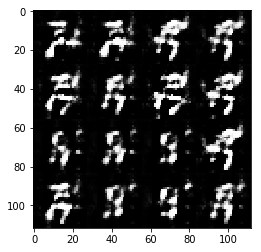

Epoch 1/2... Discriminator Loss: 0.9118... Generator Loss: 2.2703
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.4789
Epoch 1/2... Discriminator Loss: 0.7586... Generator Loss: 2.0197
Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 1.6128
Epoch 1/2... Discriminator Loss: 0.6884... Generator Loss: 1.9224
Epoch 1/2... Discriminator Loss: 0.5883... Generator Loss: 2.4020
Epoch 1/2... Discriminator Loss: 0.7159... Generator Loss: 1.9324
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 3.1496
Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 1.5879
Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 1.0359


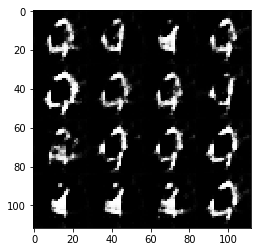

Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 1.4791
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 2.1241
Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 3.8260
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 2.0239
Epoch 1/2... Discriminator Loss: 0.5817... Generator Loss: 2.8419
Epoch 1/2... Discriminator Loss: 0.6303... Generator Loss: 2.8899
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 2.6796
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 2.8671
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 2.4307
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.9497


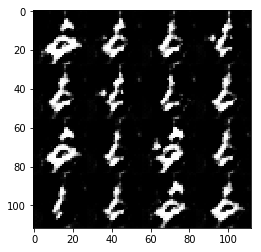

Epoch 1/2... Discriminator Loss: 0.7976... Generator Loss: 1.2103
Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 2.0357
Epoch 1/2... Discriminator Loss: 0.5947... Generator Loss: 2.4379
Epoch 1/2... Discriminator Loss: 0.4931... Generator Loss: 3.3185
Epoch 1/2... Discriminator Loss: 0.5935... Generator Loss: 2.0637
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.0425
Epoch 1/2... Discriminator Loss: 0.6130... Generator Loss: 2.5539
Epoch 1/2... Discriminator Loss: 0.6770... Generator Loss: 2.4657
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.8289
Epoch 1/2... Discriminator Loss: 0.5847... Generator Loss: 2.9217


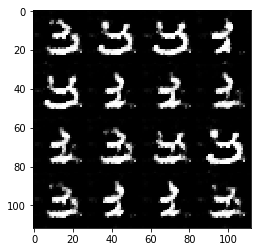

Epoch 1/2... Discriminator Loss: 0.6647... Generator Loss: 2.5785
Epoch 1/2... Discriminator Loss: 0.4808... Generator Loss: 3.2966
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 2.8531
Epoch 1/2... Discriminator Loss: 0.5457... Generator Loss: 2.2859
Epoch 1/2... Discriminator Loss: 0.5672... Generator Loss: 2.1010
Epoch 1/2... Discriminator Loss: 0.5897... Generator Loss: 2.4616
Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 3.4773
Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 4.2239
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 3.6991
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.4205


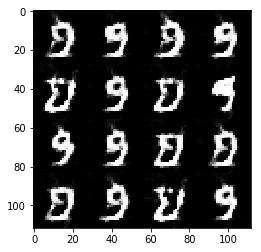

Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 1.8118
Epoch 2/2... Discriminator Loss: 0.6370... Generator Loss: 2.7371
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 4.2258
Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 2.4055
Epoch 2/2... Discriminator Loss: 0.5518... Generator Loss: 2.7815
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.1468
Epoch 2/2... Discriminator Loss: 0.6912... Generator Loss: 1.9764
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 5.6693
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 2.2758
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 2.9179


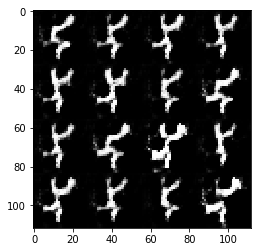

Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 3.0627
Epoch 2/2... Discriminator Loss: 0.7173... Generator Loss: 1.6306
Epoch 2/2... Discriminator Loss: 0.5392... Generator Loss: 3.2487
Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 2.4572
Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 3.2787
Epoch 2/2... Discriminator Loss: 0.7179... Generator Loss: 4.5768
Epoch 2/2... Discriminator Loss: 0.6745... Generator Loss: 1.8836
Epoch 2/2... Discriminator Loss: 0.6837... Generator Loss: 1.9374
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.5229
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.3758


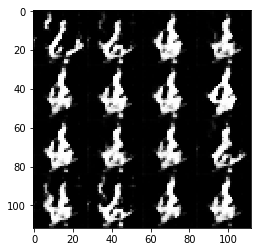

Epoch 2/2... Discriminator Loss: 0.5809... Generator Loss: 3.2296
Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 2.2137
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 3.9458
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 1.2926
Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 4.2238
Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 3.3500
Epoch 2/2... Discriminator Loss: 0.6316... Generator Loss: 3.1532
Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 2.3972
Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 3.0621
Epoch 2/2... Discriminator Loss: 1.8906... Generator Loss: 5.7124


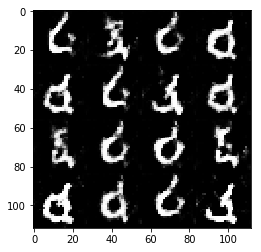

Epoch 2/2... Discriminator Loss: 0.7394... Generator Loss: 2.3125
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 1.6758
Epoch 2/2... Discriminator Loss: 0.6240... Generator Loss: 2.1586
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.0685
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 2.3303
Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 2.4252
Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 2.4237
Epoch 2/2... Discriminator Loss: 0.6388... Generator Loss: 2.0048
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 3.0237
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 2.1208


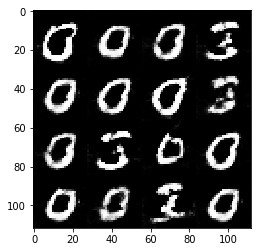

Epoch 2/2... Discriminator Loss: 0.6402... Generator Loss: 2.2219
Epoch 2/2... Discriminator Loss: 1.6293... Generator Loss: 3.2668
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 0.7427
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.6411
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.3987
Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 3.7891
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 1.8341
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 1.1091
Epoch 2/2... Discriminator Loss: 0.8085... Generator Loss: 2.5463
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 1.6894


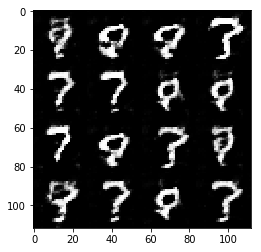

Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 3.0823
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 2.8704
Epoch 2/2... Discriminator Loss: 0.6957... Generator Loss: 1.6734
Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 2.0212
Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 3.2514
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 1.5144
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 1.7339
Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 2.6833
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 3.9130
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 2.1348


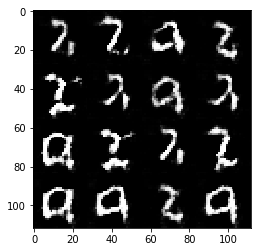

Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 1.4784
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 2.6005
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.6364
Epoch 2/2... Discriminator Loss: 0.6537... Generator Loss: 1.8809
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 1.8693
Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 2.1684
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 1.0974
Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 2.3614
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 3.0452
Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 1.8565


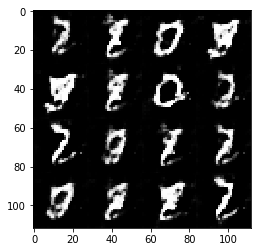

Epoch 2/2... Discriminator Loss: 0.6458... Generator Loss: 2.4611
Epoch 2/2... Discriminator Loss: 0.6615... Generator Loss: 2.0194
Epoch 2/2... Discriminator Loss: 0.6072... Generator Loss: 2.0713
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 2.5596
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 1.5562
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.4426
Epoch 2/2... Discriminator Loss: 0.6387... Generator Loss: 2.9950
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 4.9523
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.4767
Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 2.3571


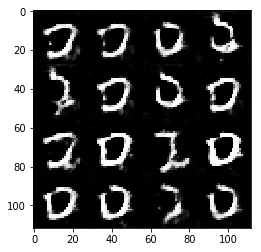

Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 1.6488
Epoch 2/2... Discriminator Loss: 1.1437... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 2.3917
Epoch 2/2... Discriminator Loss: 0.5572... Generator Loss: 2.2883
Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 2.8954
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 2.1672
Epoch 2/2... Discriminator Loss: 1.9491... Generator Loss: 4.5754
Epoch 2/2... Discriminator Loss: 0.7534... Generator Loss: 1.7679
Epoch 2/2... Discriminator Loss: 0.6706... Generator Loss: 3.3356
Epoch 2/2... Discriminator Loss: 1.5183... Generator Loss: 0.5173


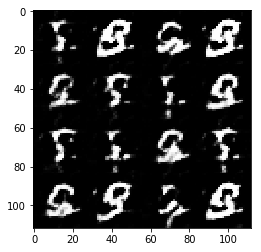

Epoch 2/2... Discriminator Loss: 0.5817... Generator Loss: 2.8522
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.1730
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 2.8863
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 2.7645
Epoch 2/2... Discriminator Loss: 0.7057... Generator Loss: 2.6236
Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.9678
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 2.0979
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.3370
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 2.0740


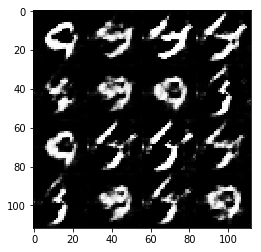

Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.6687
Epoch 2/2... Discriminator Loss: 0.6987... Generator Loss: 2.3294
Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 1.4266
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 1.0730
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 1.2907
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 1.9628
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 2.1046
Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 2.6372
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 1.9378


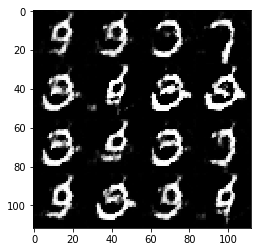

Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 2.1447
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 2.7086
Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 1.7466
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 1.8840
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 2.4762
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.5114
Epoch 2/2... Discriminator Loss: 0.8072... Generator Loss: 1.6643
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.2621
Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 0.9506


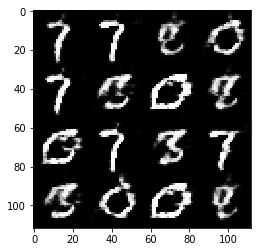

Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 2.1163
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 2.3786
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.2200
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 2.0631
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 2.5898
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.9713
Epoch 2/2... Discriminator Loss: 0.7367... Generator Loss: 2.2420
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 2.1987
Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 2.8525


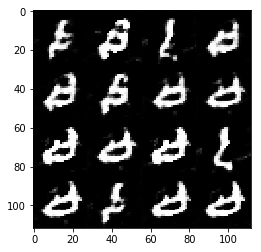

Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 1.3612
Epoch 2/2... Discriminator Loss: 0.6501... Generator Loss: 2.0553
Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 2.1182
Epoch 2/2... Discriminator Loss: 0.7015... Generator Loss: 1.9377
Epoch 2/2... Discriminator Loss: 0.7655... Generator Loss: 2.8620
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 4.4977
Epoch 2/2... Discriminator Loss: 0.7381... Generator Loss: 1.8233
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 0.6468... Generator Loss: 2.3979
Epoch 2/2... Discriminator Loss: 0.7313... Generator Loss: 2.1196


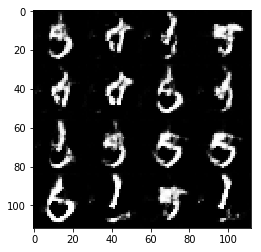

Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 1.8852
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 2.2958
Epoch 2/2... Discriminator Loss: 0.7367... Generator Loss: 1.5172
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 2.5005
Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 2.3531
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 3.9812
Epoch 2/2... Discriminator Loss: 0.6458... Generator Loss: 1.8602
Epoch 2/2... Discriminator Loss: 0.7619... Generator Loss: 2.7574
Epoch 2/2... Discriminator Loss: 0.6364... Generator Loss: 1.8650
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 3.0258


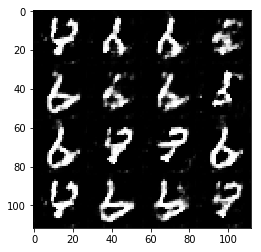

Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.2049
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 2.3139
Epoch 2/2... Discriminator Loss: 0.7137... Generator Loss: 2.0114
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 2.1514
Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.8162
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 2.1372
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 2.1574
Epoch 2/2... Discriminator Loss: 0.6810... Generator Loss: 2.0330
Epoch 2/2... Discriminator Loss: 1.2415... Generator Loss: 3.7773
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 2.4187


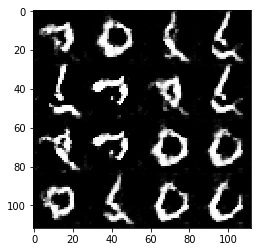

Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 2.5036
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 2.8820
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 2.4020
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 0.7077... Generator Loss: 2.5725
Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 1.7921
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.2668
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.9407
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 3.4767
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.8314


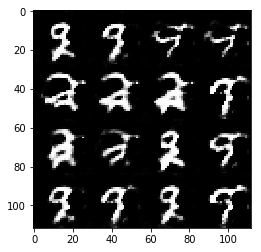

Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.8828
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 2.2507
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 1.4845
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 1.3425
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.4723
Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 2.1468
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.8161
Epoch 2/2... Discriminator Loss: 0.9117... Generator Loss: 1.1226
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 2.4638
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 1.1320


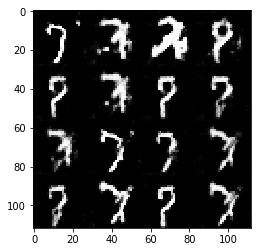

Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 2.0005
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 2.1632
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.7846
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 2.2948
Epoch 2/2... Discriminator Loss: 0.7073... Generator Loss: 2.1485


In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 2.2281
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.9338
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.8073


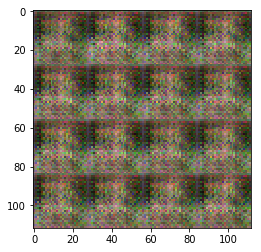

Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.6440
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 2.7692
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 2.0068
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.9987
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 2.4696
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 2.0887
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.7730


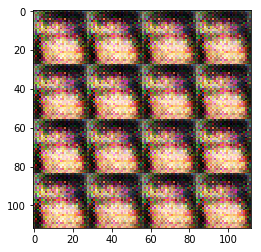

Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 2.7888
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.9445... Generator Loss: 3.6734
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.8797
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.7252
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.8244
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.6374
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.8326


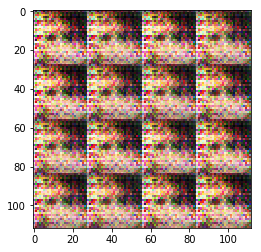

Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 2.3130
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 2.6600
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.8487
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.7065
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.3945
Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.7262
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.6391


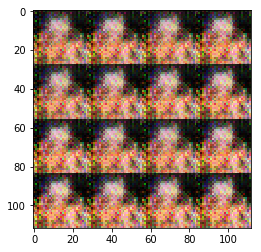

Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 2.0856
Epoch 1/1... Discriminator Loss: 1.8590... Generator Loss: 2.5832
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 1.6452
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 3.5424
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.3318
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.7908


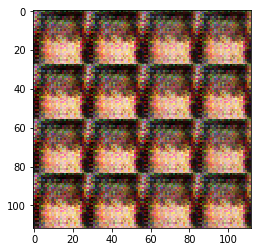

Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 2.6901
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.9243
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 2.1917
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 2.9576
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.4811
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.9982
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 2.5546
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 2.3117
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 2.2245


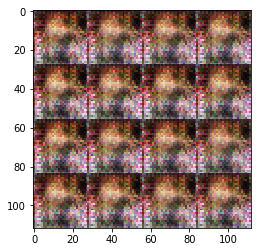

Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.6623
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 2.3748
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 3.7008
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.9796
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 3.7183
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 2.7722
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 3.4684
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 2.9919
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.6954
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 2.5649


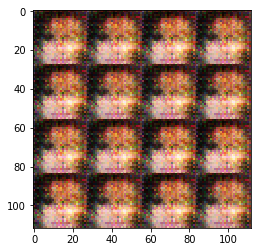

Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 2.3056
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.5581
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 5.7620
Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 3.5503
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 2.3919
Epoch 1/1... Discriminator Loss: 0.6546... Generator Loss: 2.1990
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.8623


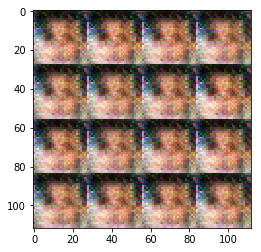

Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.8312
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 2.4433
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.7447
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.3635
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 3.8985
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 2.4198
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 3.5527
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 2.9358
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 2.8823


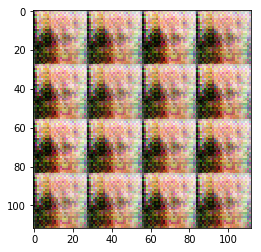

Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 3.2725
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 3.2326
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.6037
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.7827
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.9328
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.8631
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 2.0442
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 2.5092
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.9925


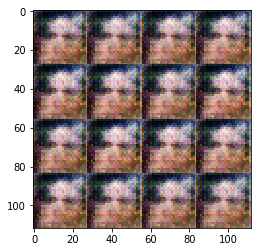

Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 4.5889
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 2.6769
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 2.1691
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 4.9678
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 3.2781
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 3.4700
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 2.0267
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.9902
Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 2.4391
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 1.8031


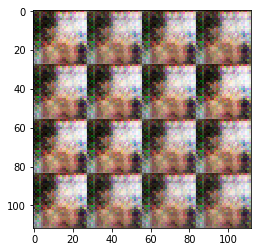

Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 2.2924
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 3.1820
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 3.0585
Epoch 1/1... Discriminator Loss: 0.5438... Generator Loss: 2.7986
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 2.6876
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 2.0401
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.3259


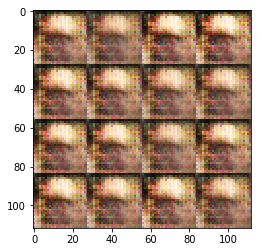

Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 1.4862
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 2.6132
Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 1.9494
Epoch 1/1... Discriminator Loss: 1.8272... Generator Loss: 2.6622
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 2.9145
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.9211


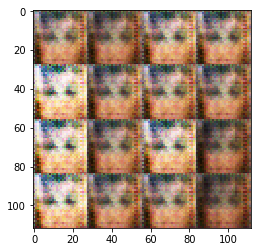

Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 2.1970
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.9430


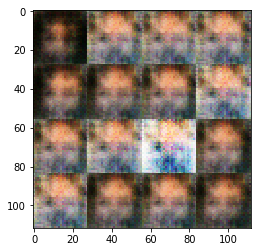

Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.6322
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.5288
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 1.7939
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 1.9475... Generator Loss: 2.5525
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.2784


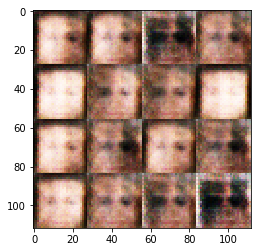

Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 1.4196
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.8768


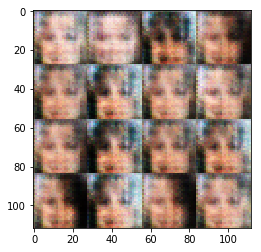

Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 1.5865
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 1.0068


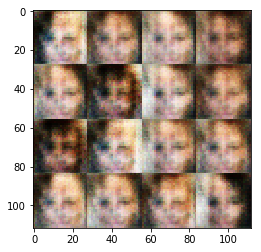

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 1.5880
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 1.2727


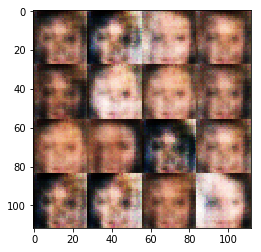

Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 1.0519


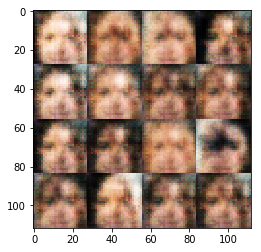

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8632


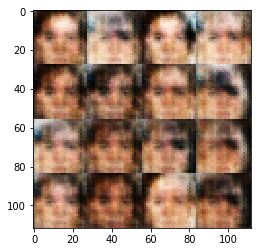

Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.3839
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.9106


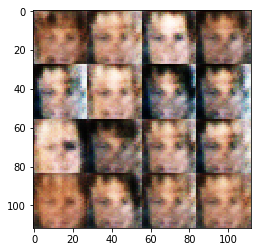

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 1.4164
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.0877


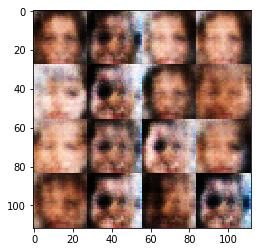

Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 1.1420


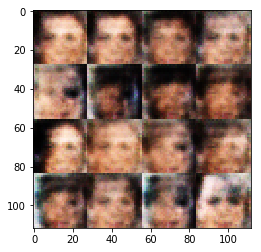

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7633


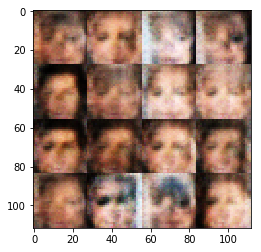

Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7208


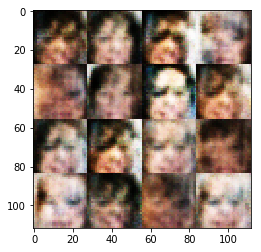

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 1.0556


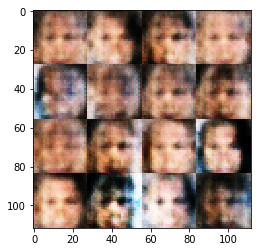

Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.8596


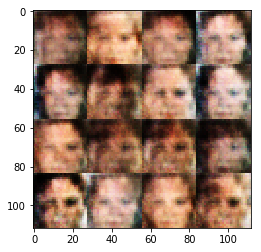

Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7843


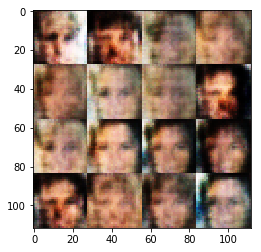

Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 1.0457


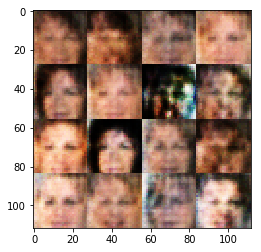

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.9007


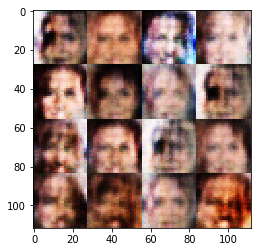

Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6219


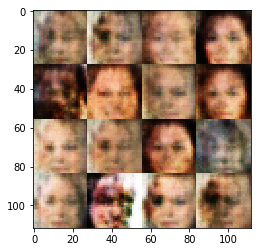

Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.8725


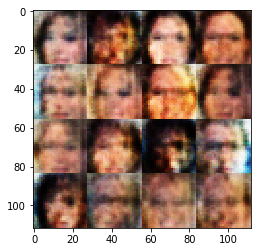

Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7777


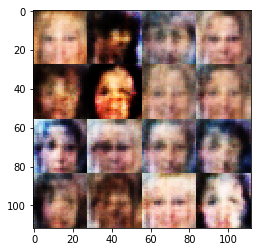

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7919


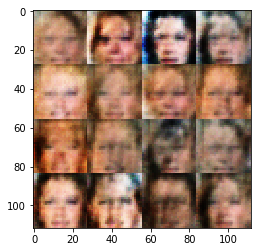

Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.9656


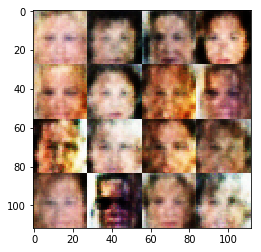

Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7523


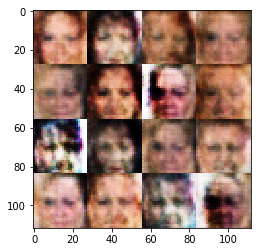

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7537


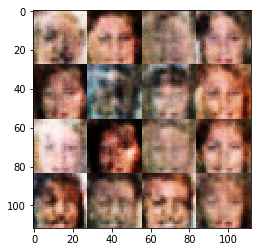

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.9213


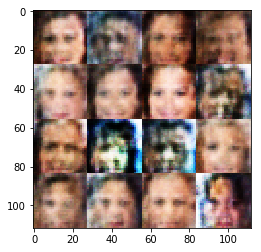

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7904


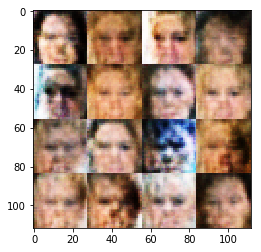

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6660


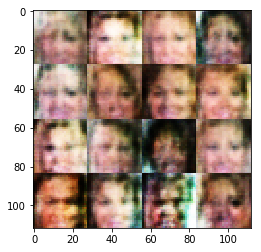

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6353


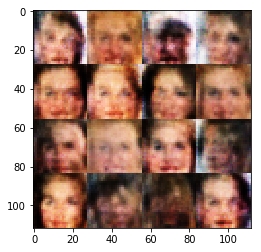

Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.9450


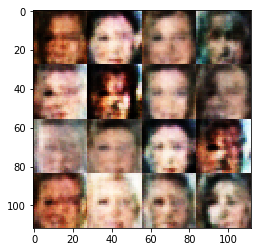

Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8501


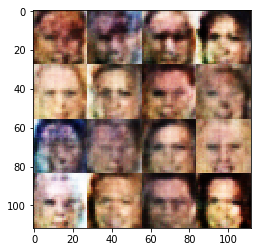

Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7333


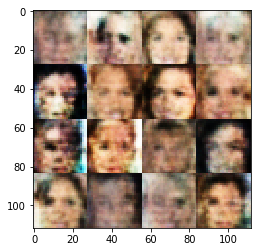

Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7695


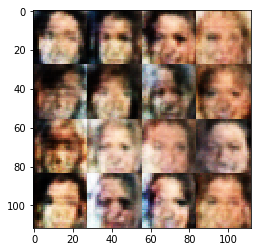

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 1.0028


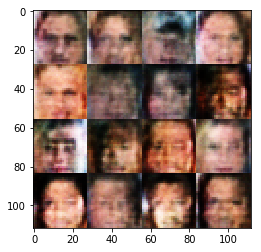

Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.9185


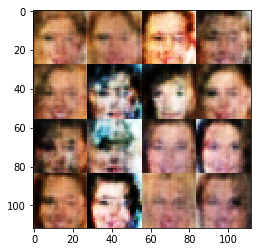

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.8346


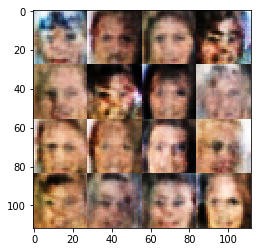

Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6664


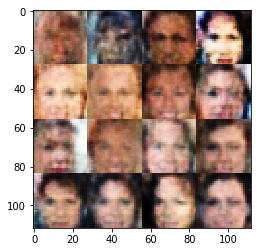

Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6793


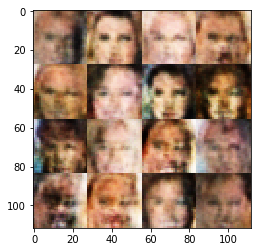

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8738


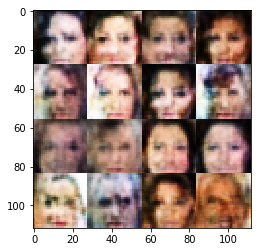

Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8484


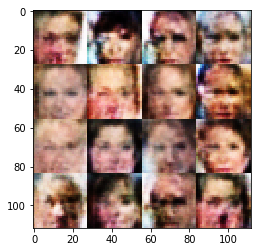

Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8202


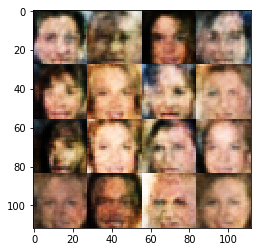

Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8204


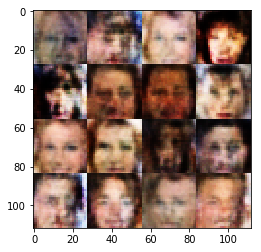

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.8973


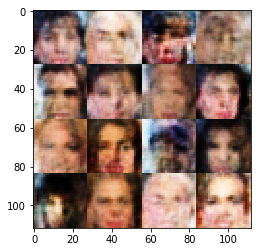

Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7916


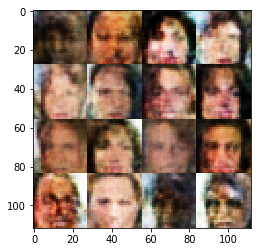

Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8407


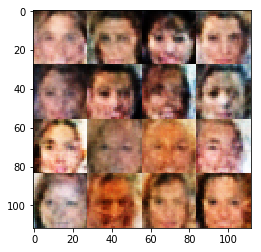

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7188


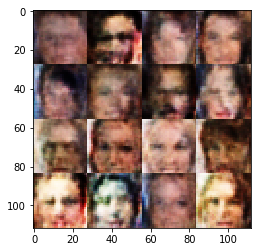

Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8169


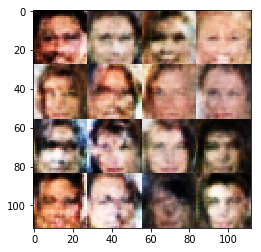

Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.9348


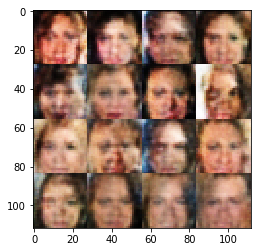

Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7103


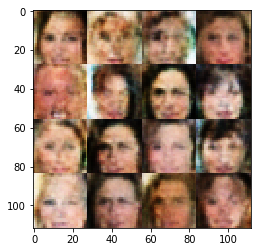

Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7071


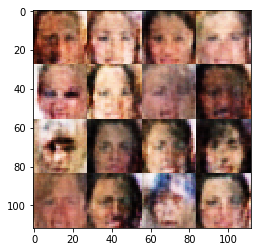

Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.9161


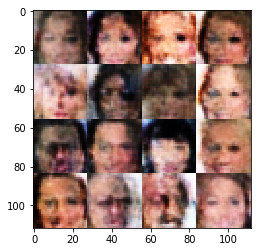

Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7864


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.